<a href="https://colab.research.google.com/github/apoorvkh/notebooks/blob/main/Person%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [ ]:
%%bash
pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
pip install mmcv-full==latest+torch1.7.0+cu101 -f https://download.openmmlab.com/mmcv/dist/index.html
git clone https://github.com/open-mmlab/mmdetection.git
cd mmdetection
pip install -r requirements/build.txt
pip install -v -e .

In [6]:
%%bash
mkdir mmdetection/checkpoints
curl -o mmdetection/checkpoints/cascade_rcnn_r50_sac_1x_coco-24bfda62.pth http://download.openmmlab.com/mmdetection/v2.0/detectors/cascade_rcnn_r50_sac_1x_coco/cascade_rcnn_r50_sac_1x_coco-24bfda62.pth

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  321M  100  321M    0     0  9009k      0  0:00:36  0:00:36 --:--:-- 8832k


# Loading Model

In [40]:
import mmcv
from mmdet.apis import init_detector, inference_detector

det_config_file = 'mmdetection/configs/detectors/cascade_rcnn_r50_sac_1x_coco.py'
det_checkpoint_file = 'mmdetection/checkpoints/cascade_rcnn_r50_sac_1x_coco-24bfda62.pth'
det_thr = 0.8

det_model = init_detector(det_config_file, det_checkpoint_file, device='cuda:0')

def load_image(image_path):
    image = mmcv.imread(image_path)
    w = image.shape[1]
    if w > 640:
        image = mmcv.imrescale(image, 640 / w)
        h, w = image.shape[:2]
    return image

def detect_boxes(image):
    person_bboxes = inference_detector(det_model, image)[0]
    return person_bboxes

def process_boxes(result, h, w, threshold=0.3):
    boxes = result / [[w, h, w, h, 1.0]]
    boxes = boxes[boxes[:, 4] >= threshold]
    return boxes

# Inference

In [28]:
from mmdet.apis import show_result_pyplot

# Sample from MS COCO
!curl -o demo.jpg https://farm6.staticflickr.com/5183/5619918180_0b11e6a97d_z.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  112k    0  112k    0     0  1354k      0 --:--:-- --:--:-- --:--:-- 1354k


/content/mmdetection/mmdet/datasets/utils.py:60: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


(3, 5)
[[0.20609262 0.46202742 0.34802115 0.84620457 0.99244386]
 [0.08638716 0.37438052 0.1900798  0.75418034 0.99141347]
 [0.48936148 0.24600167 0.77841449 0.98724912 0.98371637]]


/content/mmdetection/mmdet/apis/inference.py:186: UserWarning: "block" will be deprecated in v2.9.0,Please use "wait_time"
  warnings.warn('"block" will be deprecated in v2.9.0,'
/content/mmdetection/mmdet/core/visualization/image.py:76: UserWarning: "font_scale" will be deprecated in v2.9.0,Please use "font_size"
  warnings.warn('"font_scale" will be deprecated in v2.9.0,'


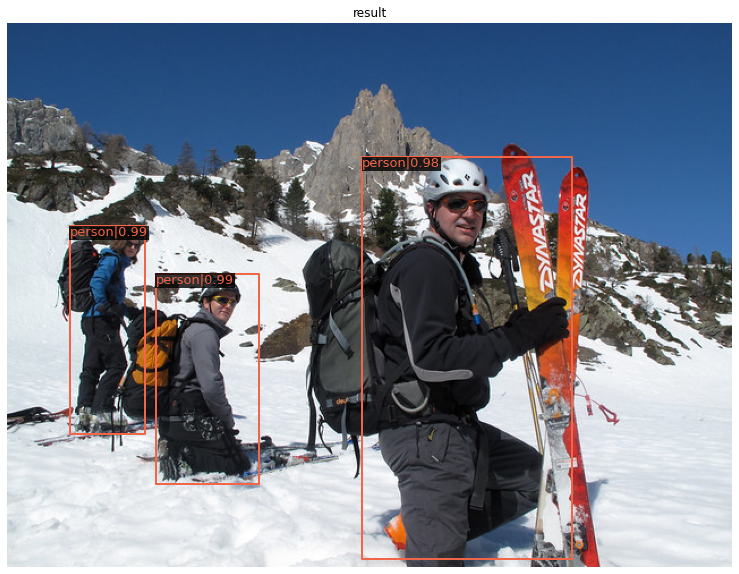

In [41]:
image = load_image('demo.jpg')
h, w = image.shape[:2]
result = detect_boxes(image)
boxes = process_boxes(result, h, w, threshold=det_thr)

print(boxes.shape)
print(boxes)

show_result_pyplot(det_model, image, [result], score_thr=det_thr)